In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')


# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/'

# Get the absolute path of the shallow utilities folder
abspath_util_shallow = '/content/drive/My Drive/Colab Notebooks/'

# Get the absolute path of the shallow models folder
abspath_model_shallow = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [55]:
import os
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.3 MB/s eta 0:00:00


In [2]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [4]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

In [6]:
# Change working directory to the absolute path of the shallow utilities folder
%cd $abspath_util_shallow

# Import the shallow utitilities
%run pmlm_utilities_shallow.ipynb

/content/drive/My Drive/Colab Notebooks


# Load the Data

In [7]:
import pandas as pd

# Load the raw training data
df_raw_train = pd.read_csv(abspath_curr + 'data/ghouls/train.csv',
                           header=0)
#df_raw_train.head()

# Make a copy of df_raw_train
df_train = df_raw_train.copy(deep=True)

# Load the raw test data
df_raw_test = pd.read_csv(abspath_curr + 'data/ghouls/test.csv',
                          header=0)
# Make a copy of df_raw_test
df_test = df_raw_test.copy(deep=True)

# Get the name of the target
target = 'type'

In [8]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,371,7


In [9]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,529,6


In [10]:
# Print the first 5 rows of df_train
df_train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [11]:
# Print the first 5 rows of df_test
df_test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


# Data Pre-Processing

## Splitting the Data

In [12]:
from sklearn.model_selection import train_test_split

# Divide the training data into training (80%) and validation (20%)
df_train, df_val = train_test_split(df_train, train_size=0.8, random_state=random_seed)

# Reset the index
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)

In [13]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,296,7


In [14]:
# Print the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,75,7


## Handling Uncommon Features

In [15]:
# Call common_var_checker
# See the implementation in pmlm_utilities.ipynb
df_common_var = common_var_checker(df_train, df_val, df_test, target)

# Print df_common_var
df_common_var

,common var
0,bone_length
1,color
2,hair_length
3,has_soul
4,id
5,rotting_flesh
6,type


In [16]:
# Get the features in the training data but not in the validation or test data
uncommon_feature_train_not_val_test = np.setdiff1d(df_train.columns, df_common_var['common var'])

# Print the uncommon features
pd.DataFrame(uncommon_feature_train_not_val_test, columns=['uncommon feature'])

,uncommon feature


In [17]:
# Get the features in the validation data but not in the training or test data
uncommon_feature_val_not_train_test = np.setdiff1d(df_val.columns, df_common_var['common var'])

# Print the uncommon features
pd.DataFrame(uncommon_feature_val_not_train_test, columns=['uncommon feature'])

,uncommon feature


In [18]:
# Get the features in the test data but not in the training or validation data
uncommon_feature_test_not_train_val = np.setdiff1d(df_test.columns, df_common_var['common var'])

# Print the uncommon features
pd.DataFrame(uncommon_feature_test_not_train_val, columns=['uncommon feature'])

,uncommon feature


#### There are no uncommon features in the threee datasets.


## Handling Identifiers

In [19]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

In [20]:
# Call id_checker on df
# See the implementation in pmlm_utilities.ipynb
df_id = id_checker(df)

# Print the first 5 rows of df_id
df_id.head()

,id
0,472
1,170
2,189
3,861
4,30


In [21]:
import numpy as np

# Remove identifiers from df_train
df_train.drop(columns=np.intersect1d(df_id.columns, df_train.columns), inplace=True)

# Remove identifiers from df_val
df_val.drop(columns=np.intersect1d(df_id.columns, df_val.columns), inplace=True)

# Remove identifiers from df_test
df_test.drop(columns=np.intersect1d(df_id.columns, df_test.columns), inplace=True)

In [22]:
# Print the first 5 rows of df_train
df_train.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0.681615,0.529227,0.625242,0.615308,white,Ghoul
1,0.480836,0.407930,0.539005,0.495069,clear,Goblin
2,0.375197,0.742953,0.320764,0.243440,blue,Ghost
3,0.626017,0.172182,0.408422,0.644941,blue,Ghoul
4,0.250770,0.246258,0.554654,0.250036,black,Ghost


In [23]:
df_val.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0.516004,0.527508,0.354857,0.760432,white,Ghoul
1,0.523729,0.318483,0.330146,0.427402,green,Goblin
2,0.500197,0.438418,0.532530,0.665522,clear,Ghoul
3,0.417300,0.377595,0.541834,0.349087,clear,Goblin
4,0.515275,0.582627,0.568721,0.534079,clear,Goblin


In [24]:
df_test.head()

,bone_length,rotting_flesh,hair_length,has_soul,color
0,0.471774,0.387937,0.706087,0.698537,black
1,0.427332,0.645024,0.565558,0.451462,white
2,0.549602,0.491931,0.660387,0.449809,black
3,0.638095,0.682867,0.471409,0.356924,white
4,0.361762,0.583997,0.377256,0.276364,black


#### I have removed the identifier from the dataset.

## There is no datetime variable in the dataset

## Handling Missing Data

In [25]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

In [26]:
# Call nan_checker on df
# See the implementation in pmlm_utilities.ipynb
df_nan = nan_checker(df)

# Print df_nan
df_nan

,var,proportion,dtype
0,type,0.587778,object


In [27]:
# Print the unique data type of variables with NaN
pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype'])

,dtype
0,object


In [28]:
# Get the variables with missing values, their proportion of missing values and data type
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# Print df_miss
df_miss

,var,proportion,dtype


In [29]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

In [30]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,296,6


In [31]:
# Print the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,75,6


In [32]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,529,6


In [33]:
from sklearn.impute import SimpleImputer

# If there are missing values
if len(df_miss['var']) > 0:
    # The SimpleImputer
    si = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

    # Impute the variables with missing values in df_train, df_val and df_test
    df_train[df_miss['var']] = si.fit_transform(df_train[df_miss['var']])
    df_val[df_miss['var']] = si.transform(df_val[df_miss['var']])
    df_test[df_miss['var']] = si.transform(df_test[df_miss['var']])

#### Missing values have been imputed

## Encoding categorical data

In [34]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

# Print the unique data type of variables in df
pd.DataFrame(df.dtypes.unique(), columns=['dtype'])

,dtype
0,float64
1,object


In [35]:
# Call cat_var_checker on df
# See the implementation in pmlm_utilities.ipynb
df_cat = cat_var_checker(df)

# Print the dataframe
df_cat

,var,nunique
0,color,6
1,type,4


In [36]:
# One-hot-encode the categorical features in the combined data
df = pd.get_dummies(df, columns=np.setdiff1d(np.intersect1d(df.columns, df_cat['var']), [target]))

# Print the first 5 rows of df
df.head()

,bone_length,rotting_flesh,hair_length,has_soul,type,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,0.681615,0.529227,0.625242,0.615308,Ghoul,False,False,False,False,False,True
1,0.480836,0.407930,0.539005,0.495069,Goblin,False,False,False,True,False,False
2,0.375197,0.742953,0.320764,0.243440,Ghost,False,False,True,False,False,False
3,0.626017,0.172182,0.408422,0.644941,Ghoul,False,False,True,False,False,False
4,0.250770,0.246258,0.554654,0.250036,Ghost,True,False,False,False,False,False


In [37]:
from sklearn.preprocessing import LabelEncoder

# The LabelEncoder
le = LabelEncoder()

# Encode categorical target in the combined data
df[target] = le.fit_transform(df[target].astype(str))

# Print the first 5 rows of df
df.head()

,bone_length,rotting_flesh,hair_length,has_soul,type,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,0.681615,0.529227,0.625242,0.615308,1,False,False,False,False,False,True
1,0.480836,0.407930,0.539005,0.495069,2,False,False,False,True,False,False
2,0.375197,0.742953,0.320764,0.243440,0,False,False,True,False,False,False
3,0.626017,0.172182,0.408422,0.644941,1,False,False,True,False,False,False
4,0.250770,0.246258,0.554654,0.250036,0,True,False,False,False,False,False


In [38]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

In [39]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,296,11


In [40]:
# Print the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,75,11


In [41]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,529,11


#### I have one hot encoded the color and type

## Splitting Feature and target

In [42]:
# Get the feature matrix
X_train = df_train[np.setdiff1d(df_train.columns, [target])].values
X_val = df_val[np.setdiff1d(df_val.columns, [target])].values
X_test = df_test[np.setdiff1d(df_test.columns, [target])].values

# Get the target vector
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

## Scaling the Data

In [43]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

In [44]:
# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_val = ss.transform(X_val)

# Standardize the test data
X_test = ss.transform(X_test)

# Hyperparameter Tuning

#### Model Pipeline

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=random_seed),
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          'hgbc': HistGradientBoostingClassifier(random_state=random_seed)}


In [46]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [47]:

# Get the:
# feature matrix and target velctor in the combined training and validation data
# target vector in the combined training and validation data
# PredefinedSplit
# See the implementation in pmlm_utilities.ipynb
X_train_val, y_train_val, ps = get_train_val_ps(X_train, y_train, X_val, y_val)

## Grid Search

#### Param Grid

In [48]:
param_grids = {}

In [49]:
# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -4, 10 ** -3]

# The parameter grid of C
C_grid = [0.1, 1, 10]

# Update param_grids
param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid}]

In [50]:
# The grids for alpha
alpha_grids = [10 ** i for i in range(-2,-1)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-4, -1)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

In [51]:
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

In [52]:
# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]

In [53]:
# Make directory
directory = os.path.dirname(abspath_curr + 'result/resulthw3/cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

#### Tuning

In [57]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=10,
                      cv=ps,
                      return_train_score=True)

    # Fit the pipeline
    gs = gs.fit(X_train_val, y_train_val)

    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])

    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score',
                         'std_test_score',
                         'mean_train_score',
                         'std_train_score',
                         'mean_fit_time',
                         'std_fit_time',
                         'mean_score_time',
                         'std_score_time']

    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=abspath_curr + 'result/resulthw3/cv_results/GridSearchCV/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)
# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])


,best_score,best_param,best_estimator
0,0.769772,"{'model__alpha': 0.01, 'model__learning_rate_i...","(MLPClassifier(alpha=0.01, early_stopping=True..."
1,0.735064,"{'model__C': 10, 'model__tol': 1e-05}","(LogisticRegression(C=10, class_weight='balanc..."
2,0.731838,"{'model__learning_rate': 0.01, 'model__min_sam...",(HistGradientBoostingClassifier(learning_rate=...
3,0.730319,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(max_features='sqrt', ..."


## Randomized Search


#### Param Dist



In [58]:
param_dists = {}

In [59]:
from scipy.stats import uniform, randint

# Update param_grids for MLPC
param_dists['mlpc'] = {
    'model__alpha': uniform(loc=1e-5, scale=1e-2),  # Uniform distribution for alpha
    'model__learning_rate_init': uniform(loc=1e-4, scale=0.0999)  # Uniform distribution for learning_rate_init
}

# Update param_grids for RFC
param_dists['rfc'] = {
    'model__min_samples_split': randint(2, 101),  # Discrete uniform distribution for min_samples_split
    'model__min_samples_leaf': randint(1, 101)  # Discrete uniform distribution for min_samples_leaf
}

# Update param_grids for HGBC
param_dists['hgbc'] = {
    'model__learning_rate': uniform(loc=0.001, scale=0.999),  # Uniform distribution for learning_rate
    'model__min_samples_leaf': randint(1, 101)  # Discrete uniform distribution for min_samples_leaf
}

# Update param_dists for LR
param_dists['lr'] = {
    'model__C': uniform(loc=0.1, scale=9.9),  # Uniform distribution for C
    'model__tol': uniform(loc=1e-5, scale=9.999e-3)  # Uniform distribution for tol
}


In [60]:
# Make directory
directory = os.path.dirname(abspath_curr + 'result/resulthw3/cv_results/RandomizedSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

#### Tuning

In [61]:
from sklearn.model_selection import RandomizedSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by RandomizedSearchCV
best_score_params_estimator_rs = []

for acronym in pipes.keys():
    # RandomizedSearchCV
    rs = RandomizedSearchCV(estimator=pipes[acronym],
                            param_distributions=param_dists[acronym],
                            scoring='f1_macro',
                            n_jobs=2,
                            cv=ps,
                            random_state=random_seed,
                            return_train_score=True)

    # Fit the pipeline
    rs = rs.fit(X_train_val, y_train_val)

    # Update best_score_param_estimators
    best_score_params_estimator_rs.append([rs.best_score_, rs.best_params_, rs.best_estimator_])

    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(rs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])

    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score',
                         'std_test_score',
                         'mean_train_score',
                         'std_train_score',
                         'mean_fit_time',
                         'std_fit_time',
                         'mean_score_time',
                         'std_score_time']

    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=abspath_curr + 'result/resulthw3/cv_results/RandomizedSearchCV/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_rs in descending order of the best_score_
best_score_params_estimator_rs = sorted(best_score_params_estimator_rs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_rs
pd.DataFrame(best_score_params_estimator_rs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.781746,"{'model__alpha': 0.0015701864044243652, 'model...","(MLPClassifier(alpha=0.0015701864044243652, ea..."
1,0.735064,"{'model__C': 7.34674002393291, 'model__tol': 0...","(LogisticRegression(C=7.34674002393291, class_..."
2,0.718660,"{'model__min_samples_leaf': 3, 'model__min_sam...","((DecisionTreeClassifier(max_features='sqrt', ..."
3,0.679931,"{'model__learning_rate': 0.7222767734945579, '...",(HistGradientBoostingClassifier(learning_rate=...


#### The best model is achieved by MLPC by randomized search

# Model Selection

In [63]:
# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_rs, best_params_rs, best_estimator_rs = best_score_params_estimator_rs[0]

In [64]:
best_score_rs

0.7817460317460317

In [65]:
best_estimator_rs

Pipeline(steps=[('model',
                 MLPClassifier(alpha=0.0015701864044243652, early_stopping=True,
                               learning_rate_init=0.015683852581586645,
                               random_state=42))])

In [66]:
explainer = shap.Explainer(best_estimator_rs.predict, X_train)

In [67]:
shap_values = explainer(X_test)

ExactExplainer explainer: 530it [01:42,  4.90it/s]


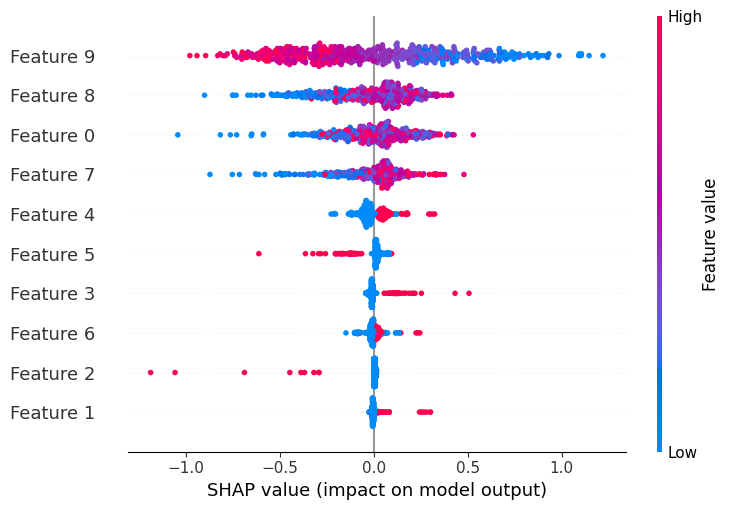

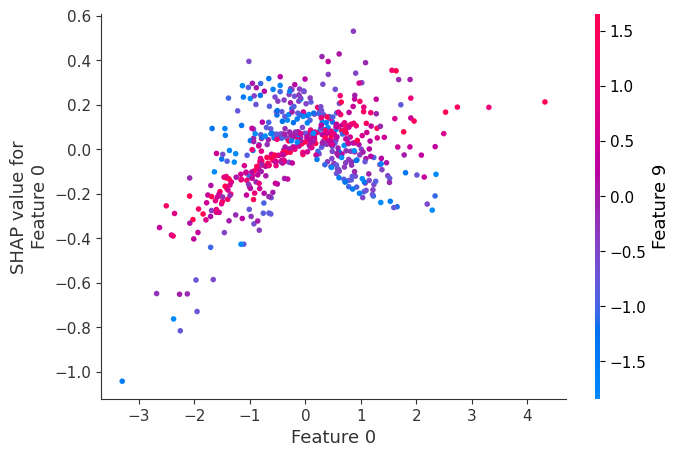

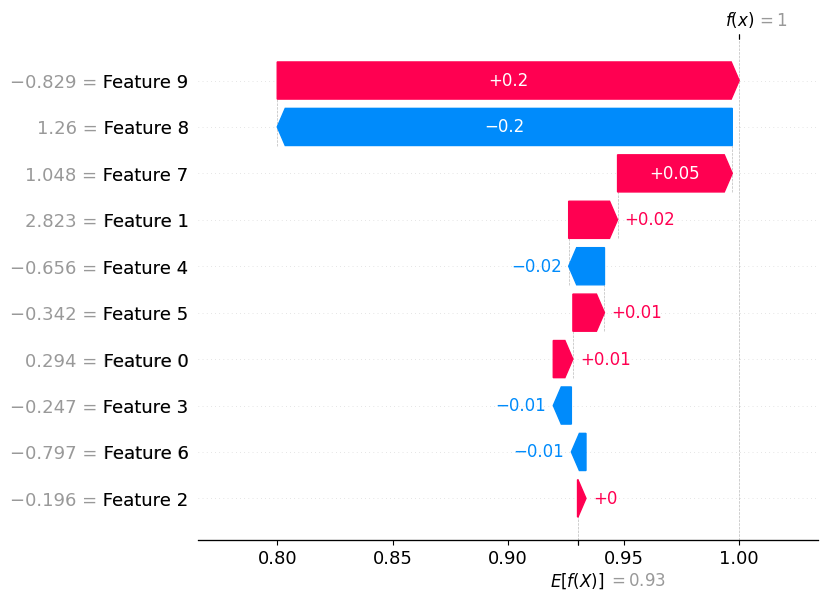

In [75]:
shap.summary_plot(shap_values, X_test)

# Dependence plot for a specific feature
shap.dependence_plot( 'Feature 0', shap_values.values, X_test)

# Waterfall plot for a single prediction
shap.plots.waterfall(shap_values[0])

In [73]:
print("Features in X_test:", df_test.columns.tolist())

# If your SHAP values are in a DataFrame or have feature names, check them as well
print("Features in SHAP values:", shap_values.feature_names)

Features in X_test: ['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'type', 'color_black', 'color_blood', 'color_blue', 'color_clear', 'color_green', 'color_white']
Features in SHAP values: ['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9']


# Submission File

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/resulthw3/submission/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# Get the prediction on the testing data using best_model
y_test_pred = best_estimator_rs.predict(X_test)



# Get the submission dataframe
df_submit = pd.DataFrame(np.hstack((np.arange(1, y_test_pred.shape[0] + 1).reshape(-1, 1), y_test_pred.reshape(-1, 1))),
                         columns=['id', target]).astype({'id':int, target:int})

# Generate the submission file
df_submit.to_csv(abspath_curr + '/result/resulthw3/submission/submission.csv', index=False)

# Conclusion
#### 1. I did RandomizedSearchCv with different distributions to get the best model.
